### Import libraries required

In [1]:
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import re
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from scipy import spatial
import networkx as nx

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/suthatipchaithep/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/suthatipchaithep/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import pycrfsuite
from pythainlp.tokenize import sent_tokenize, word_tokenize
from pythainlp.corpus import thai_stopwords
import emoji

In [3]:
#df = pd.read_csv('/Users/suthatipchaithep/Documents/Text_summarize_project/#ปังชา.xlsx - Sheet1.csv')
df = pd.read_excel('/Users/suthatipchaithep/Documents/Text_summarize_project/Paragon.xlsx')
df[:5]

,full_text,quote,reply,retweet,favorite
0,“แบมแบม กันต์พิมุกต์” ร่วมแสดงความอาลัยกับการจ...,4,1,1524,1679
1,วันนี้ม๊าและคุณแบงค์และอากู๋ ได้มาร่วมพิธีสวดอ...,12,26,3646,4274
2,พ่อเด็ก 14 #กราดยิงพารากอน กราบขอขมาศพหนุงหนิง...,60,29,3473,1420
3,ข้อความของแบมแบมทั้งหมด ส่งตรงถึงพี่หนิงแล้วนะ...,130,73,4183,4172
4,BamBam GOT7 ฝากข้อความแทนความรู้สึกถึงคุณหนุงห...,239,25,7794,6316


In [4]:
df

,full_text,quote,reply,retweet,favorite
0,“แบมแบม กันต์พิมุกต์” ร่วมแสดงความอาลัยกับการจ...,4,1,1524,1679
1,วันนี้ม๊าและคุณแบงค์และอากู๋ ได้มาร่วมพิธีสวดอ...,12,26,3646,4274
2,พ่อเด็ก 14 #กราดยิงพารากอน กราบขอขมาศพหนุงหนิง...,60,29,3473,1420
3,ข้อความของแบมแบมทั้งหมด ส่งตรงถึงพี่หนิงแล้วนะ...,130,73,4183,4172
4,BamBam GOT7 ฝากข้อความแทนความรู้สึกถึงคุณหนุงห...,239,25,7794,6316
...,...,...,...,...,...
1788,#ข่าวด่วน รวบแล้วมือโพสต์ภาพบีบีกัน ป่วนห้างดั...,0,0,0,2
1789,ยังกังวล! นักท่องเที่ยวจีนวูบเกือบ 30% กังวลคว...,0,0,0,2
1790,ความรุนแรงในสังคม ที่เป็นรากฐานของเหตุกราดยิง...,0,0,2,6
1791,6 ต.ค 65 #กราดยิงหนองบัวลำภู 3 ต.ค 66 #กราดยิง...,0,0,0,1


In [5]:
# Combine all rows in the 'full_text' column into a single variable named 'Text'
thai_text = ' '.join(df['full_text'])

### Tokenizing this paragraph into a list of sentences

In [5]:
# ตัดประโยคออกก่อน
#thai_sentences = sent_tokenize(thai_text, engine="tltk")

In [4]:
# ใช้แต่ละเทรดเป็นประโยค
thai_sentences = df['full_text'].tolist()

### Preprocessing is necessary

In [5]:
thai_stopwords = list(thai_stopwords())

In [6]:
def replace_url(text):
    URL_PATTERN = r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))"""
    return re.sub(URL_PATTERN, 'xxurl', text)

def ungroup_emoji(toks):
    res = []
    for tok in toks:
        if emoji.emoji_count(tok) == len(tok):
            for char in tok:
                res.append(char)
        else:
            res.append(tok)
    return res

def replace_eng(text):
    eng = re.compile('[a-zA-Z]')
    return eng.sub('',text)

def process_text(text):
    res = text.lower().strip() 
    res = replace_url(res)
    res = replace_eng(res)
    res = [word for word in word_tokenize(res) if word not in thai_stopwords and not re.search(pattern=r"\s+" , string=word) and '#' not in word]
    #res = [word for word in word_tokenize(res) if not re.search(pattern=r"\s+" , string=word)]
    res = ungroup_emoji(res)
    return res

In [7]:
thai_sentence_tokens = [[words for words in process_text(sentence)] for sentence in thai_sentences]

 ### convert text data into numerical form, we will 1st calculate word embedding

In [8]:
w2v=Word2Vec(thai_sentence_tokens,vector_size=1,min_count=1, epochs=1000)
thai_sentence_embeddings=[[w2v.wv[word][0] for word in words] for words in thai_sentence_tokens]
thai_max_len=max([len(tokens) for tokens in thai_sentence_tokens])
thai_sentence_embeddings=[np.pad(embedding,(0,thai_max_len-len(embedding)),'constant') for embedding in thai_sentence_embeddings]

### calculate the similarity matrix

In [9]:
thai_similarity_matrix = np.zeros([len(thai_sentence_tokens), len(thai_sentence_tokens)])
for i,row_embedding in enumerate(thai_sentence_embeddings):
    for j,column_embedding in enumerate(thai_sentence_embeddings):
        thai_similarity_matrix[i][j]=1-spatial.distance.cosine(row_embedding,column_embedding)

### Convert the similarity matrix to a network/graph and apply PageRank

In [10]:
thai_nx_graph = nx.from_numpy_array(thai_similarity_matrix)
thai_scores = nx.pagerank(thai_nx_graph, tol=1.0e-3)

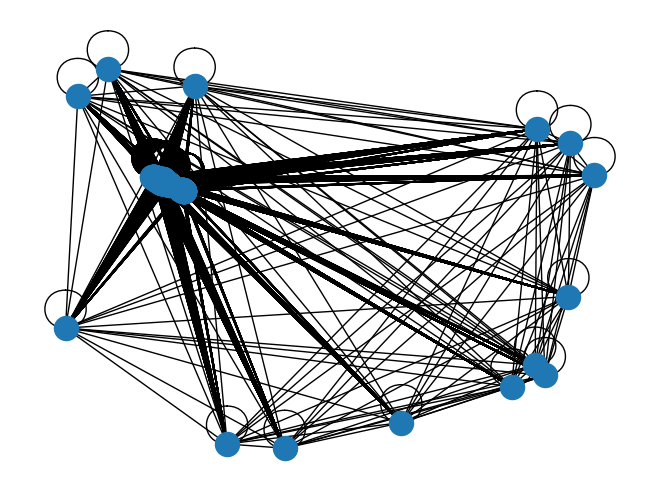

In [35]:
#nx.draw(thai_nx_graph)

### Taking the top 4 for summary

In [19]:
df

,full_text,quote,reply,retweet,favorite
0,“แบมแบม กันต์พิมุกต์” ร่วมแสดงความอาลัยกับการจ...,4,1,1524,1679
1,วันนี้ม๊าและคุณแบงค์และอากู๋ ได้มาร่วมพิธีสวดอ...,12,26,3646,4274
2,พ่อเด็ก 14 #กราดยิงพารากอน กราบขอขมาศพหนุงหนิง...,60,29,3473,1420
3,ข้อความของแบมแบมทั้งหมด ส่งตรงถึงพี่หนิงแล้วนะ...,130,73,4183,4172
4,BamBam GOT7 ฝากข้อความแทนความรู้สึกถึงคุณหนุงห...,239,25,7794,6316
...,...,...,...,...,...
1788,#ข่าวด่วน รวบแล้วมือโพสต์ภาพบีบีกัน ป่วนห้างดั...,0,0,0,2
1789,ยังกังวล! นักท่องเที่ยวจีนวูบเกือบ 30% กังวลคว...,0,0,0,2
1790,ความรุนแรงในสังคม ที่เป็นรากฐานของเหตุกราดยิง...,0,0,2,6
1791,6 ต.ค 65 #กราดยิงหนองบัวลำภู 3 ต.ค 66 #กราดยิง...,0,0,0,1


In [20]:
# Convert the dictionary to a DataFrame
thai_scores_df = pd.DataFrame(list(thai_scores.items()), columns=['index', 'textrank_score'])

In [22]:
result_df = pd.merge(df, thai_scores_df, how='left', left_index=True, right_on='index')

# Drop the redundant 'index' column
result_df = result_df.drop(columns=['index'])

In [23]:
result_df

,full_text,quote,reply,retweet,favorite,textrank_score
0,“แบมแบม กันต์พิมุกต์” ร่วมแสดงความอาลัยกับการจ...,4,1,1524,1679,0.000510
1,วันนี้ม๊าและคุณแบงค์และอากู๋ ได้มาร่วมพิธีสวดอ...,12,26,3646,4274,0.000561
2,พ่อเด็ก 14 #กราดยิงพารากอน กราบขอขมาศพหนุงหนิง...,60,29,3473,1420,0.000574
3,ข้อความของแบมแบมทั้งหมด ส่งตรงถึงพี่หนิงแล้วนะ...,130,73,4183,4172,0.000587
4,BamBam GOT7 ฝากข้อความแทนความรู้สึกถึงคุณหนุงห...,239,25,7794,6316,0.000568
...,...,...,...,...,...,...
1788,#ข่าวด่วน รวบแล้วมือโพสต์ภาพบีบีกัน ป่วนห้างดั...,0,0,0,2,0.000590
1789,ยังกังวล! นักท่องเที่ยวจีนวูบเกือบ 30% กังวลคว...,0,0,0,2,0.000587
1790,ความรุนแรงในสังคม ที่เป็นรากฐานของเหตุกราดยิง...,0,0,2,6,0.000551
1791,6 ต.ค 65 #กราดยิงหนองบัวลำภู 3 ต.ค 66 #กราดยิง...,0,0,0,1,0.000586


In [25]:
# Assuming 'full_text' is the column name in df that contains the text
result_df['len'] = result_df['full_text'].apply(len)
result_df

,full_text,quote,reply,retweet,favorite,textrank_score,len
0,“แบมแบม กันต์พิมุกต์” ร่วมแสดงความอาลัยกับการจ...,4,1,1524,1679,0.000510,279
1,วันนี้ม๊าและคุณแบงค์และอากู๋ ได้มาร่วมพิธีสวดอ...,12,26,3646,4274,0.000561,159
2,พ่อเด็ก 14 #กราดยิงพารากอน กราบขอขมาศพหนุงหนิง...,60,29,3473,1420,0.000574,197
3,ข้อความของแบมแบมทั้งหมด ส่งตรงถึงพี่หนิงแล้วนะ...,130,73,4183,4172,0.000587,86
4,BamBam GOT7 ฝากข้อความแทนความรู้สึกถึงคุณหนุงห...,239,25,7794,6316,0.000568,190
...,...,...,...,...,...,...,...
1788,#ข่าวด่วน รวบแล้วมือโพสต์ภาพบีบีกัน ป่วนห้างดั...,0,0,0,2,0.000590,177
1789,ยังกังวล! นักท่องเที่ยวจีนวูบเกือบ 30% กังวลคว...,0,0,0,2,0.000587,159
1790,ความรุนแรงในสังคม ที่เป็นรากฐานของเหตุกราดยิง...,0,0,2,6,0.000551,89
1791,6 ต.ค 65 #กราดยิงหนองบัวลำภู 3 ต.ค 66 #กราดยิง...,0,0,0,1,0.000586,160


In [26]:
result_df.to_csv('Paragon.csv')

In [14]:
thai_top_sentence={sentence:thai_scores[index] for index,sentence in enumerate(thai_sentences)}
thai_top=dict(sorted(thai_top_sentence.items(), key=lambda x: x[1], reverse=True)[:10])

In [15]:
thai_top

{'ออกหมายจับเพิ่มอีก 3 คน เอี่ยวแก๊งขายปืนให้เด็ก 14 ปี ก่อเหตุยิงในพารากอน  #TheBangkokInsight #พารากอน #กราดยิงพารากอน #กราดยิงสยามพารากอน': 0.0006054584085741913,
 'ประชาสัมพันธ์นะคะ สำหรับใครที่ยังไม่ทราบ สามารถกระจายบอกต่อให้กับบุคคลหรือญาติที่ได้รับผลกระทบได้เลยนะคะ  #กราดยิง #กราดยิงสยามพารากอน #กราดยิงพารากอน #พารากอน #สยามพารากอน ': 0.0006024008330449127,
 'มือปืนวัย 14 อ้างมีคนจะทำร้าย-หูแว่วถูกสั่งให้ยิง    #พารากอน #สำนักงานตำรวจแห่งชาติ #สยามพารากอน #กราดยิง #กราดยิงพารากอน #theroom44 ': 0.0006016798929392616,
 'ด่วน!! ขอหมายจับ 3 บุคคล ที่เกี่ยวข้องกับกรณี เยาวชนวัย 14 ปี ก่อเหตุยิงในห้างสยามพารากอน Cr:ดาวแปดแฉก  #กราดยิงพารากอน': 0.0006016486635080498,
 'พ่อ ด.ช. 14 โผล่ร่วมงานศพ ตะวัน" พร้อมแสดงความเสียใจกับการกระทำของลูกชาย  #เด็ก14 #กราดยิง #พารากอน #กราดยิงสยามพารากอน #กราดยิงพารากอน #ไทยรัฐนิวส์โชว์ #ไทยรัฐทีวี32 ': 0.0006014678652845586,
 'ขอแสดงความเสียใจกับครอบครัวผู้เสียชีวิต และก็ ผู้บาดเจ็บทุกคนด้วย ขอให้อีเด็กเหี้ยนั้นได้รับโทษสูงสุด ขอให้ชีวิตมันชิบหายทั้งคร

In [15]:
for sent in thai_sentences:
    if sent in thai_top.keys():
        print(sent)

ขอแสดงความเสียใจกับครอบครัวผู้เสียชีวิต และก็ ผู้บาดเจ็บทุกคนด้วย ขอให้อีเด็กเหี้ยนั้นได้รับโทษสูงสุด ขอให้ชีวิตมันชิบหายทั้งครอบครัว #กราดยิง #กราดยิงพารากอน #อย่าโทษเกมส์
ถ้าเด็กคนนี้และครอบครัวไม่ได้รับโทษอะไรเลยสักนิดก็ต้องพิจารณาแล้วนะว่ามันเกิดอะไรกับกฏหมายไทย คนที่เสียชีวิตและครอบครัวเค้าทำผิดอะไร  ถึงต้องมารับโทษด้วยชีวิตและความเสียใจของเค้าอ่ะ #กราดยิงพารากอน
มือปืนวัย 14 อ้างมีคนจะทำร้าย-หูแว่วถูกสั่งให้ยิง    #พารากอน #สำนักงานตำรวจแห่งชาติ #สยามพารากอน #กราดยิง #กราดยิงพารากอน #theroom44 
อยากรู้แม้ปิดเครื่องก็แจ้งเตือนได้นี่คือยังไง? แล้วต้องรอตั้ง 1 ปี แทนที่จะทำมาตั้งแต่เหตุการณ์ครั้งก่อนๆแล้วเสือกไม่ทำกัน  #กราดยิงสยามพารากอน #กราดยิงพารากอน #กราดยิง #พารากอน #สยามพารากอน 
ประชาสัมพันธ์นะคะ สำหรับใครที่ยังไม่ทราบ สามารถกระจายบอกต่อให้กับบุคคลหรือญาติที่ได้รับผลกระทบได้เลยนะคะ  #กราดยิง #กราดยิงสยามพารากอน #กราดยิงพารากอน #พารากอน #สยามพารากอน 
พ่อแม่มือปืนเค้ารู้เรื่องยัง ?  ทำไมไม่มีใครไปงานศพ ไม่มีใครมาขอขมา ?  หรือต้องรอให้คนในบ้านตายก่อนถึงจะสำนึก ว่าเรื่องนี้ ลูกกู